# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
from sklearn.metrics import f1_score, accuracy_score
import torch
import os
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

10.4.0


In [ ]:
# Обучение будет происходить локально
# Потому что коллаб заколебал отваливаться в неподходящий момент, 
# Так что тут проверяем можно ли обучать на нашем GPU
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 27 22:01:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              4W /   80W |      12MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
#from skimage import io
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Давайте посмотрим на наших героев внутри датасета.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc, model

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs
#random_characters = int(np.random.uniform(0,1000))
#ex_img, true_label = val_dataset[random_characters]
#probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

def val_predict_F1(model, val_dataset):
    

    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]
    f1 = f1_score(actual_labels, preds_class, average='micro')

    print("F1-оценка:", f1)

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
def train(train_loader, val_loader, model_name, model, epochs, base_lr):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=base_lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc, model = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model.state_dict(), 'weights2/{}_{}.pth'.format(model_name, epoch))

    return history

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
batch_size = 156
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### Обучение простой модели

In [ ]:
n_classes = len(np.unique(train_val_labels))

# Очень простая сеть
model_simple = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Sequential(
    nn.Linear(in_features=2400, out_features=4096, bias=True),
    nn.Dropout(p=0.1),
    nn.ReLU(inplace=True),
    ),
    nn.Sequential(
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.Dropout(p=0.1),
    nn.ReLU(inplace=True),
    ),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True),
    nn.Dropout(p=0.2),
).to(DEVICE)

In [ ]:
model_name = 'sm'
history = train(train_loader, val_loader, model_name, model=model_simple, epochs=10, base_lr=1e-3)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.218833678269418


epoch:  10%|█         | 1/10 [01:26<12:54, 86.10s/it]


Epoch 001 train_loss: 3.2188     val_loss 2.7657 train_acc 0.1145 val_acc 0.2170
loss 2.241117926234386


epoch:  20%|██        | 2/10 [02:51<11:24, 85.61s/it]


Epoch 002 train_loss: 2.2411     val_loss 1.7862 train_acc 0.3744 val_acc 0.5004
loss 1.4378830898384416


epoch:  30%|███       | 3/10 [04:16<09:58, 85.48s/it]


Epoch 003 train_loss: 1.4379     val_loss 1.2416 train_acc 0.6004 val_acc 0.6590
loss 0.9368003016217088


epoch:  40%|████      | 4/10 [05:42<08:34, 85.69s/it]


Epoch 004 train_loss: 0.9368     val_loss 1.0394 train_acc 0.7302 val_acc 0.7186
loss 0.6175917659005402


epoch:  50%|█████     | 5/10 [07:07<07:06, 85.33s/it]


Epoch 005 train_loss: 0.6176     val_loss 0.9560 train_acc 0.8164 val_acc 0.7516
loss 0.3539444559986815


epoch:  60%|██████    | 6/10 [08:33<05:42, 85.68s/it]


Epoch 006 train_loss: 0.3539     val_loss 0.9781 train_acc 0.8930 val_acc 0.7736
loss 0.17653526561382782


epoch:  70%|███████   | 7/10 [10:01<04:18, 86.30s/it]


Epoch 007 train_loss: 0.1765     val_loss 1.0456 train_acc 0.9454 val_acc 0.7866
loss 0.12511424221398837


epoch:  80%|████████  | 8/10 [11:26<02:52, 86.05s/it]


Epoch 008 train_loss: 0.1251     val_loss 1.2670 train_acc 0.9623 val_acc 0.7724
loss 0.07406425502485124


epoch:  90%|█████████ | 9/10 [12:52<01:25, 85.79s/it]


Epoch 009 train_loss: 0.0741     val_loss 1.2783 train_acc 0.9778 val_acc 0.7933
loss 0.05302188505742328


epoch: 100%|██████████| 10/10 [14:17<00:00, 85.72s/it]


Epoch 010 train_loss: 0.0530     val_loss 1.4548 train_acc 0.9853 val_acc 0.7793


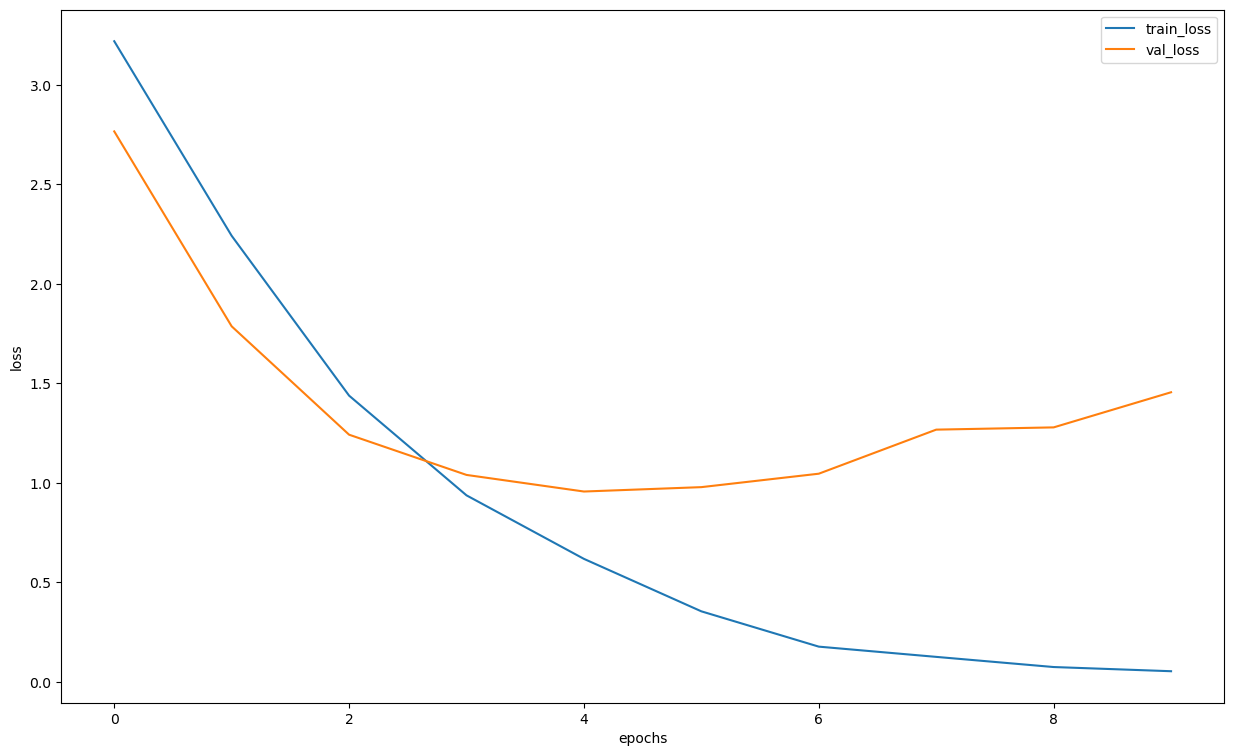

In [ ]:
# Построим график чтобы прям посмотреть на какой эпохе пошел оверфиттинг

loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_simple, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_simple, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.7


Наилучшая модель была на пятой эпохе (на графике она четвертая, ну очевидно же, ежу же понятно, как иначе то)

### Обучение RESNET50

In [ ]:
# feature_extracting = False - вычисляем градиент у всей сети (обучаем всю модель)
# feature_extracting = True - обучаем только FC
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
from efficientnet_pytorch import EfficientNet
from torchvision import transforms, models
def initialize_model(model_name, feature_extract):

    model_ft = None
    # Количество классов в датасете
    num_classes = len(os.listdir(TRAIN_DIR))

    if model_name == 'efficientnet-b0':
        """ efficientnet-b0
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    elif model_name == 'efficientnet-b2':
        """ efficientnet-b2
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b2')
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft._fc.in_features
        # меняем последний слой _fc на наш код
        model_ft._fc = nn.Sequential(
            nn.Linear(in_features=num_ftrs, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    elif model_name == 'resnet50':
        """ resnet50
        """
        model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # меняем последний слой _fc на наш код
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == 'resnet101':
        """ resnet101
        """
        model_ft = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        # отключает обновление градиентов у замороженных слоев
        set_parameter_requires_grad(model_ft, feature_extract)
        # получаем кол-во нейронов входящих в последний слой
        num_ftrs = model_ft.fc.in_features
        # меняем последний слой _fc на наш код
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [ ]:
# очистка кеша
del model_simple
torch.cuda.empty_cache()

In [ ]:
model_name = 'resnet101'
resnet101_model = initialize_model(model_name, feature_extract=True).to(DEVICE)

In [ ]:
history = train(train_loader, val_loader, model_name, model=resnet101_model, epochs=10, base_lr=1e-2)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.4848545476717359


epoch:  10%|█         | 1/10 [02:22<21:19, 142.17s/it]


Epoch 001 train_loss: 1.4849     val_loss 0.8930 train_acc 0.6289 val_acc 0.7721
loss 0.5249880377111393


epoch:  20%|██        | 2/10 [04:41<18:42, 140.32s/it]


Epoch 002 train_loss: 0.5250     val_loss 0.7517 train_acc 0.8632 val_acc 0.8061
loss 0.31919512756919166


epoch:  30%|███       | 3/10 [07:00<16:18, 139.77s/it]


Epoch 003 train_loss: 0.3192     val_loss 0.7239 train_acc 0.9245 val_acc 0.8131
loss 0.21838820567213962


epoch:  40%|████      | 4/10 [09:20<13:58, 139.75s/it]


Epoch 004 train_loss: 0.2184     val_loss 0.7269 train_acc 0.9526 val_acc 0.8137
loss 0.15349807544827984


epoch:  50%|█████     | 5/10 [11:39<11:38, 139.68s/it]


Epoch 005 train_loss: 0.1535     val_loss 0.7308 train_acc 0.9742 val_acc 0.8152
loss 0.11424513619635863


epoch:  60%|██████    | 6/10 [13:59<09:18, 139.71s/it]


Epoch 006 train_loss: 0.1142     val_loss 0.7230 train_acc 0.9843 val_acc 0.8212
loss 0.08771334210659518


epoch:  70%|███████   | 7/10 [16:18<06:58, 139.40s/it]


Epoch 007 train_loss: 0.0877     val_loss 0.7449 train_acc 0.9908 val_acc 0.8156
loss 0.07072481668498898


epoch:  80%|████████  | 8/10 [18:37<04:38, 139.28s/it]


Epoch 008 train_loss: 0.0707     val_loss 0.7541 train_acc 0.9954 val_acc 0.8139
loss 0.058497436267740066


epoch:  90%|█████████ | 9/10 [20:56<02:19, 139.22s/it]


Epoch 009 train_loss: 0.0585     val_loss 0.7441 train_acc 0.9974 val_acc 0.8187
loss 0.04724517319982876


epoch: 100%|██████████| 10/10 [23:15<00:00, 139.59s/it]


Epoch 010 train_loss: 0.0472     val_loss 0.7708 train_acc 0.9985 val_acc 0.8175


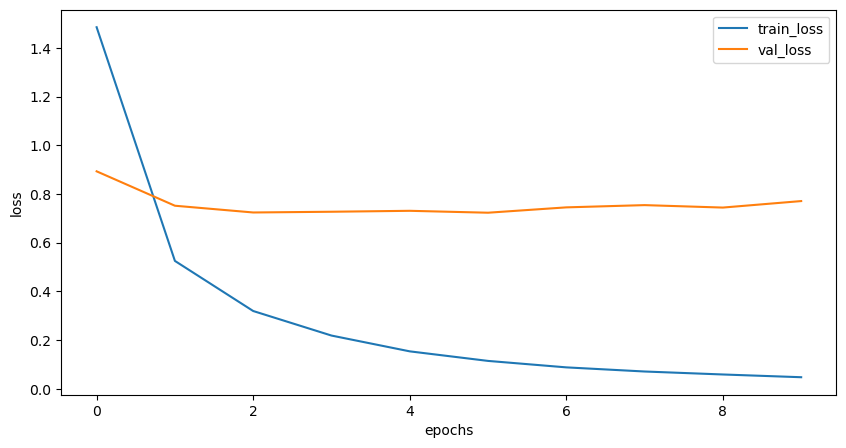

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet101_model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet101_model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
f1 = f1_score(actual_labels, y_pred, average='micro')
print('f1', f1)


f1 0.8


Наилучшая модель была на третьей эпохе (в экспериментах с менее "мощным" резнетом50 лосс на валидационной выборке продолжал падать все 10 эпох)

### Обучение efficientnet-b0

In [ ]:
model_name = 'efficientnet-b0'
efficientnet_model = initialize_model(model_name, feature_extract=True).to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/livonian_horde/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.6MB/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
history = train(train_loader, val_loader, model_name, model=efficientnet_model, epochs=10, base_lr=1e-3)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.8531139274867252


epoch:  10%|█         | 1/10 [01:52<16:51, 112.36s/it]


Epoch 001 train_loss: 1.8531     val_loss 1.2349 train_acc 0.5621 val_acc 0.6693
loss 0.8414765335099774


epoch:  20%|██        | 2/10 [03:40<14:40, 110.06s/it]


Epoch 002 train_loss: 0.8415     val_loss 0.7451 train_acc 0.7850 val_acc 0.8026
loss 0.5244593502640064


epoch:  30%|███       | 3/10 [05:29<12:46, 109.49s/it]


Epoch 003 train_loss: 0.5245     val_loss 0.6570 train_acc 0.8673 val_acc 0.8248
loss 0.3653243821767099


epoch:  40%|████      | 4/10 [07:18<10:55, 109.27s/it]


Epoch 004 train_loss: 0.3653     val_loss 0.5995 train_acc 0.9088 val_acc 0.8380
loss 0.2607406365149294


epoch:  50%|█████     | 5/10 [09:06<09:04, 108.91s/it]


Epoch 005 train_loss: 0.2607     val_loss 0.5909 train_acc 0.9400 val_acc 0.8374
loss 0.18732818872869847


epoch:  60%|██████    | 6/10 [10:54<07:14, 108.66s/it]


Epoch 006 train_loss: 0.1873     val_loss 0.5608 train_acc 0.9596 val_acc 0.8504
loss 0.12429872800156648


epoch:  70%|███████   | 7/10 [12:43<05:25, 108.54s/it]


Epoch 007 train_loss: 0.1243     val_loss 0.5638 train_acc 0.9782 val_acc 0.8550
loss 0.08414370337379792


epoch:  80%|████████  | 8/10 [14:31<03:36, 108.42s/it]


Epoch 008 train_loss: 0.0841     val_loss 0.5709 train_acc 0.9898 val_acc 0.8538
loss 0.05516256807386568


epoch:  90%|█████████ | 9/10 [16:19<01:48, 108.36s/it]


Epoch 009 train_loss: 0.0552     val_loss 0.5795 train_acc 0.9961 val_acc 0.8558
loss 0.036934656164536464


epoch: 100%|██████████| 10/10 [18:09<00:00, 108.94s/it]


Epoch 010 train_loss: 0.0369     val_loss 0.5809 train_acc 0.9992 val_acc 0.8558


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

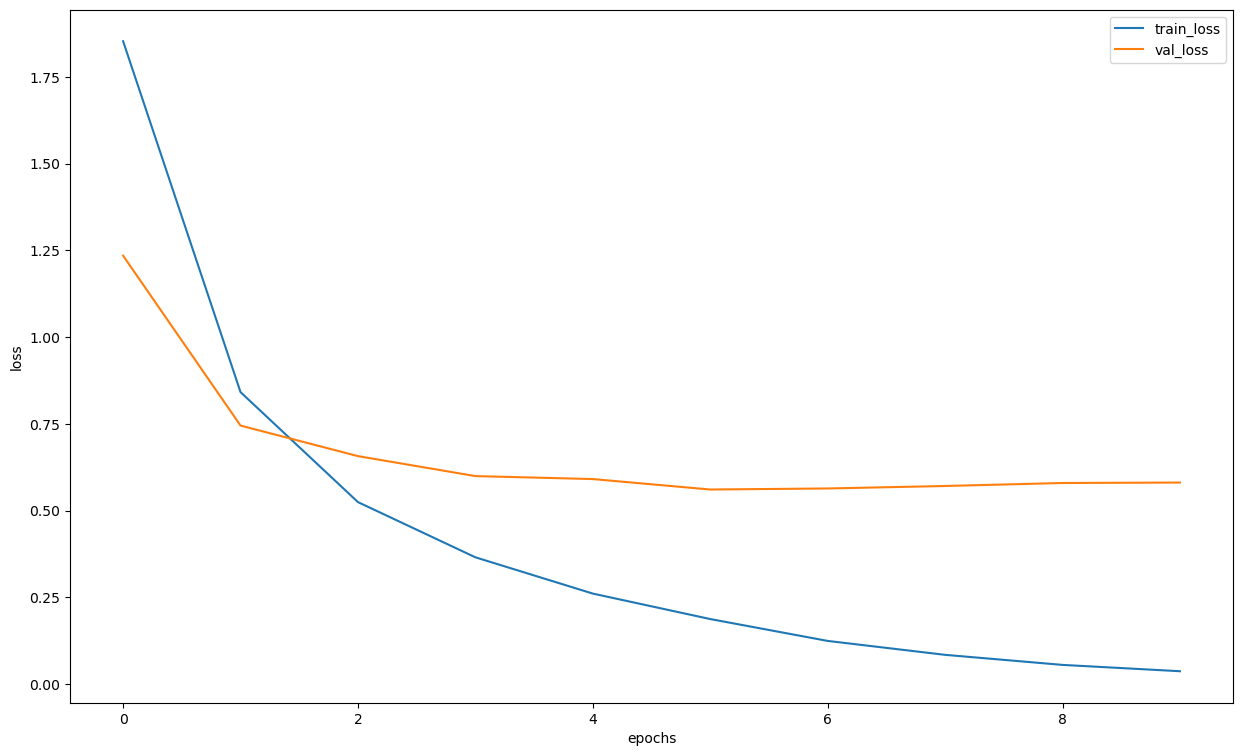

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(efficientnet_model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(efficientnet_model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
f1 = f1_score(actual_labels, y_pred, average='micro')
print('f1', f1)

f1 0.9


Наилучшая модель была на шестой эпохе

### Делаем ансамбль предсказаний

In [ ]:
model_simple.load_state_dict(torch.load('weights2/sm_4.pth', weights_only=True))
model_simple.to(DEVICE)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Sequential(
    (0): Linear(in_fea

In [ ]:
resnet101_model.load_state_dict(torch.load(r'weights2\resnet101_4.pth', weights_only=True))
resnet101_model.to(DEVICE)

In [ ]:
efficientnet_model.load_state_dict(torch.load(r'weights2\efficientnet-b0_5.pth', weights_only=True))
efficientnet_model.to(DEVICE)

In [ ]:
def val_predict_F1(model, val_dataset):
    
    idxs = [i for i in range(len(val_dataset))]
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    
    actual_labels = [val_dataset[id][1] for id in idxs]
    f1 = f1_score(actual_labels, y_pred, average='micro')

    print("F1-оценка:", f1)

In [ ]:
print('model_simple:', val_predict_F1(model_simple, val_dataset))
print('resnet101_model:', val_predict_F1(resnet101_model, val_dataset))
print('efficientnet_model:', val_predict_F1(efficientnet_model, val_dataset))

F1-оценка: 0.7516239969430646
model_simple: None
F1-оценка: 0.8173481085212075
resnet101_model: None
F1-оценка: 0.8561329766908674
efficientnet_model: None


### Сабмитим на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(efficientnet_model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('my_submission_efficientnet.csv', index=False)

my_submission.csv - simple model - 91 score on Kaggle

resnet50_model - 80 score

efficientnet_model - 87 score

Итог, лучше всего себя показала простая модель

### Пробуем bagging (ensemble averaging)

предсказания нескольких моделей усредняются для получения окончательного предсказания

In [ ]:
# Функция для усреднения предсказаний
def ensemble_predict(models, test_loader):
    with torch.no_grad():
        all_preds = []
        labels = []
        for i, model in enumerate(models):
            model.eval()
            preds = []
            with torch.no_grad():
                for inputs, label in tqdm(test_loader):                  
                    inputs = inputs.to(DEVICE)
                    outputs = model(inputs).cpu()
                    preds.append(outputs)
                    if i==0:
                        labels.extend(label)
            all_preds.append(torch.cat(preds))

        # Усреднение предсказаний
        avg_preds = torch.mean(torch.stack(all_preds), dim=0)
        _, predicted = torch.max(avg_preds, 1)
    return predicted, labels



In [ ]:
models = [model_simple, resnet101_model, efficientnet_model]
predicted, true_labels = ensemble_predict(models, val_loader)
predicted = list(predicted.cpu().numpy())

100%|██████████| 34/34 [00:26<00:00,  1.28it/s]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 

print("Результаты ансамблирования моделей: усреднение предсказаний")
print("f1_score", f1_score(true_labels, predicted, average='micro'))
print("accuracy_score", accuracy_score(true_labels, predicted))
precision = precision_score(true_labels, predicted, average='micro') 
# Recall 
recall = recall_score(true_labels, predicted, average='micro')
print("Precision:", precision) 
print("Recall:", recall) 

Результаты ансамблирования моделей: усреднение предсказаний
f1_score 0.9142147497134123
accuracy_score 0.9142147497134123
Precision: 0.9142147497134123
Recall: 0.9142147497134123


In [ ]:
# загрузим наш инкодер
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

# получим список классов
# label_encoder.classes_[i] - можно убедиться, какому классу, какое кодированное число какому классу соответствует
yticklabels = label_encoder.classes_

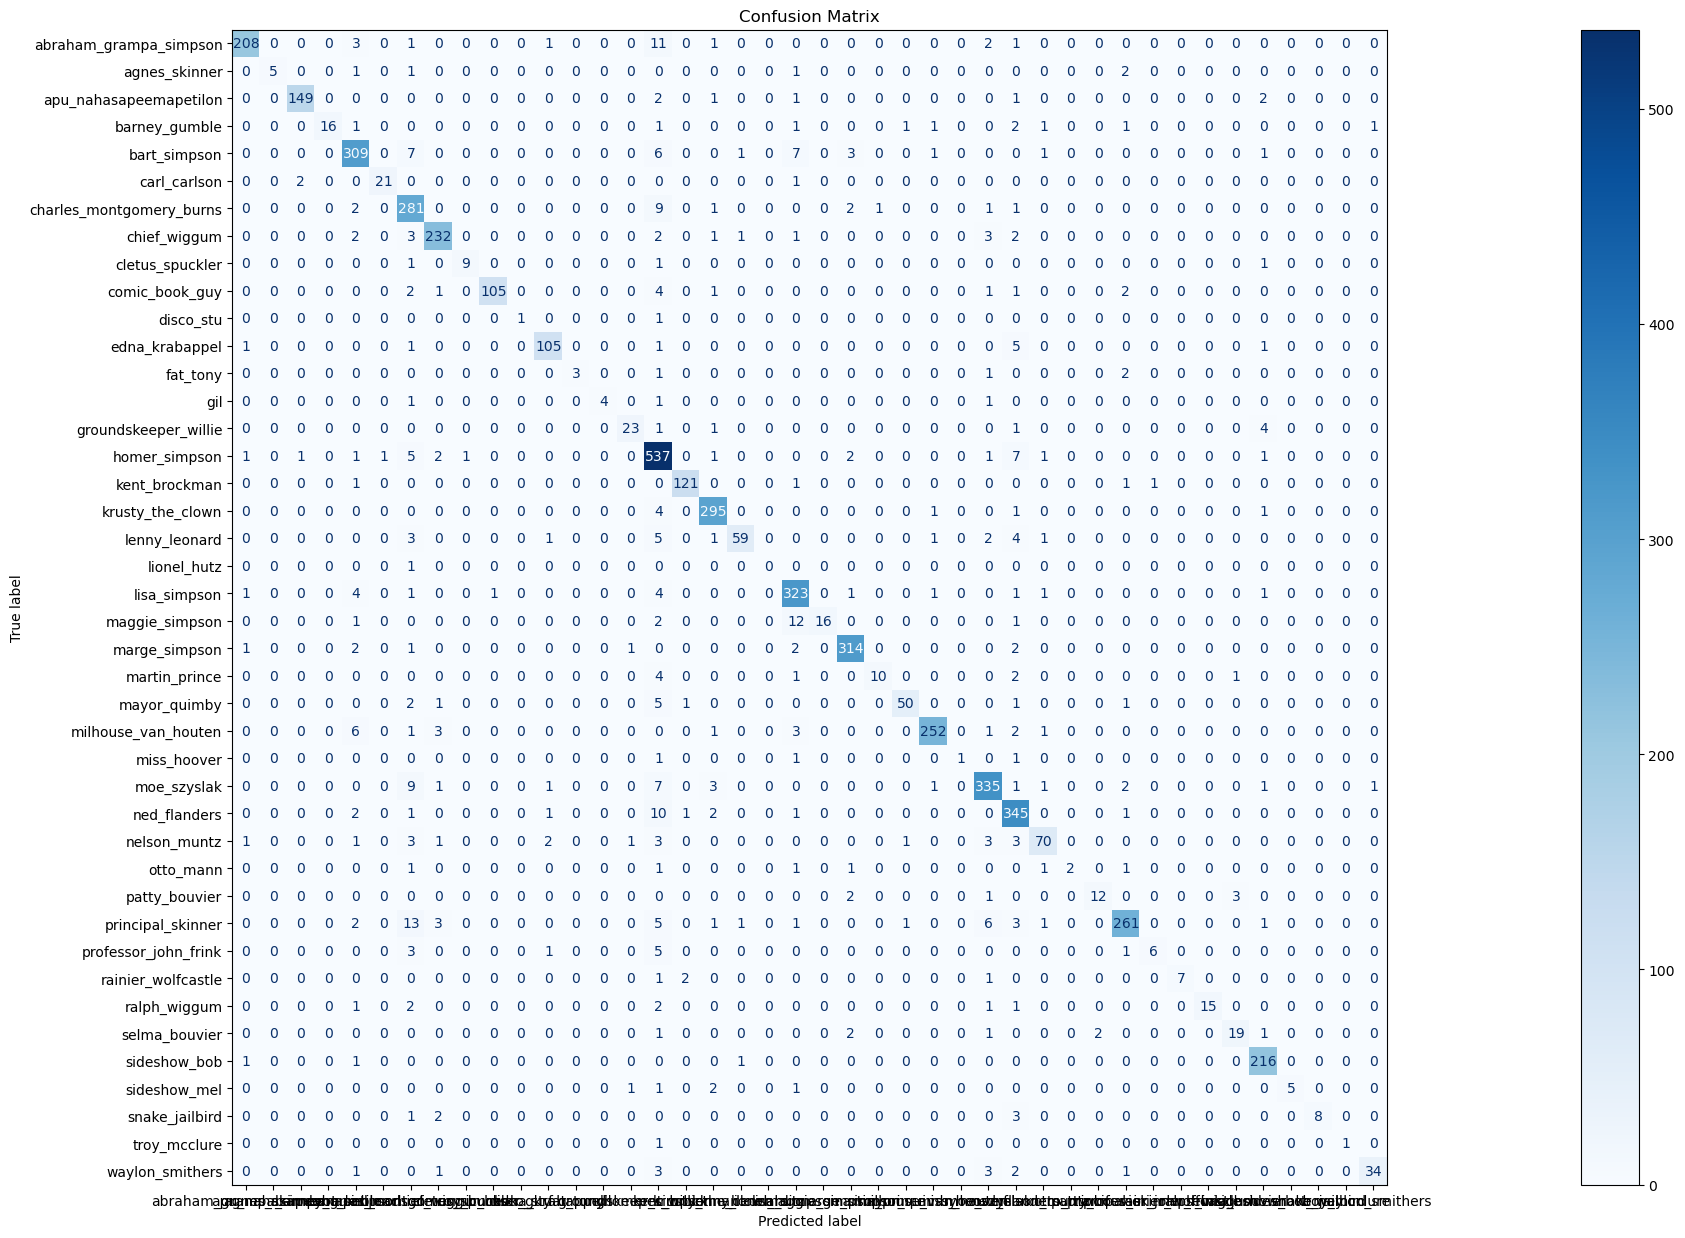

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
cm = confusion_matrix(true_labels, predicted)
fig, ax = plt.subplots(figsize=(50, 15)) 
# Plot the confusion matrix
#sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", cbar=False, vmax = 30, yticklabels = yticklabels, xticklabels = yticklabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = yticklabels)
disp.plot(ax=ax, cmap=plt.cm.Blues)
#disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Видим, что качество значительно улучшилось, закидываем предсказания на Kaggle

In [ ]:
# Функция для усреднения предсказаний
def ensemble_predict_kaggle(models, test_loader):
    
    with torch.no_grad():
        all_preds = []
        for model in models:
            
            logits = []
            with torch.no_grad():
                for inputs in tqdm(test_loader):                  
                    inputs = inputs.to(DEVICE)
                    model.eval()
                    outputs = model(inputs).cpu()
                    logits.append(outputs)
            all_preds.append(torch.cat(logits))

        # Усреднение предсказаний
        avg_preds = torch.mean(torch.stack(all_preds), dim=0)
        #_, predicted = torch.max(avg_preds, 1)
    return avg_preds

In [ ]:
# Предсказания ансамбля
models = [model_simple, resnet101_model, efficientnet_model]
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = ensemble_predict_kaggle(models, test_loader)

100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('druk_submission_ansamble.csv', index=False)

### Итоговый вывод

Бэггинг, который усреднял пресказания показал наилучший результат, повысив метрику F1 с 91% до 96%. При этом обучение мета-модели не дало прироста в точности, получилось 90%. Для улучшения точности стоило бы сделать датасет более сбалансированным